# Example 3.1: Softening and Hardening versus Pull-Out 
# PO-LF-LM-EL-SH

@author: rosoba

## Idealization of the pull-out problem
The one-dimensional idealization of the pull-out looks as follows

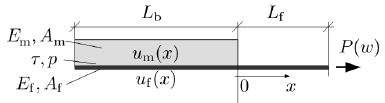

## Model parameters

The parameters and variables involved in the are grouped according geometry, material behavior, measured response, internal state and subsidiary integration parameters that will be resolved during the model derivation. In this classification we also associate the mathematical symbols with the Python variable name introduced in the next cell.

**Geometrical variables:**

| Python | Parameter | Description | 
| :- | :-: | :- |
| `A_f` | $A_\mathrm{f}$ |  Cross section area modulus of the reinforcement |
| `A_m` | $A_\mathrm{m}$ |  Cross section area modulus of the matrix |
| `p_b` | $p_\mathrm{b}$ |  Perimeter of the reinforcement                  |
| `L_b` | $L_\mathrm{b}$ |  Length of the bond zone of the pulled-out bar   |
| `x`   | $x$            |  Longitudinal coordinate |

**Material parameters:**

| Python | Parameter | Description | 
| :- | :-: | :- |
| `E_f`     | $E_\mathrm{f}$ |  Young's modulus of the reinforcement |
| `E_m`     | $E_\mathrm{m}$ |  Young's modulus of the matrix        |
| `MATS`    | $\tau(s)$      |  Multi-linear bond-slip model         |

(`MATS` is used to denote "Material Time Stepper" -- equivalent to user-subroutine in Abaqus, or user material in ATENA) 

**Control parameter:**

| Python | Parameter | Description | 
| :- | :-: | :- |
| `P` | $P$ | Pullout force |
| `w` | $w$ | pullout control  displacement

**State parameter:**

There are no state parameters included. 

 - What is the consequence? The material has no memory.
 - What happens upon unloading?

**Let's import the packages:**

In [19]:
%matplotlib notebook
import sympy as sp # symbolic algebra package
import numpy as np # numerical package
import matplotlib.pyplot as plt # plotting package
sp.init_printing() # enable nice formating of the derived expressions
import ipywidgets as ipw

## Construct a tri-nonlinear bond-slip law  
To indicate how the below examples are implemented let us define a a piece-wise linear function with three branches constituting the bond-slip behavior. It can be used to exemplify how to implement material models in standard non-linear finite-element codes for structural analysis. In codes like `ANSYS, Abaques, ATENA, Diana`, the spatial integration of the stresses and stiffnesses is based on the so called **predictor**, **corrector** scheme.

This simply means that the material model must provide two functions
 1. the stress evaluation for a given strain increment
 2. the derivative of stress with respect to the strain increment, i.e. the material stiffness.
In our case of a bond-slip law, we need to provide two functions
\begin{align}
 \tau(s) \\
 \frac{\mathrm{d} \tau}{ \mathrm{d} s}
\end{align}.

The tri-linear function can be readily constructed using the already known `Piecewise` function provied in `sympy`

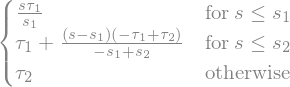

In [20]:
s = sp.symbols('s')
tau_1, s_1, tau_2, s_2 = sp.symbols(r'tau_1, s_1, tau_2, s_2')
tau_s = sp.Piecewise(
    (tau_1 / s_1 * s, s <= s_1),
    (tau_1 + (tau_2-tau_1) / (s_2-s_1) * (s - s_1), s <= s_2),
    (tau_2, True)
)
tau_s

The derivative is obtained as

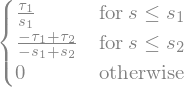

In [23]:
d_tau_s = sp.diff(tau_s, s)
d_tau_s

Vectorized evaluation of these two functions that can run over large arrays of data can obtained using the `sympy.lambdify` method.

In [24]:
get_tau_s = sp.lambdify((s, tau_1, tau_2, s_1, s_2), tau_s, 'numpy')
get_d_tau_s = sp.lambdify((s, tau_1, tau_2, s_1, s_2), d_tau_s, 'numpy')

This function provides a sufficient range of qualitative shapes to demonstrate and discuss the effect of softening and hardening behavior of the interface material. Let us setup a figure `fig` with two axes `ax1` and `ax2` to verify if the defined function is implemented correctly

In [25]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

<IPython.core.display.Javascript object>


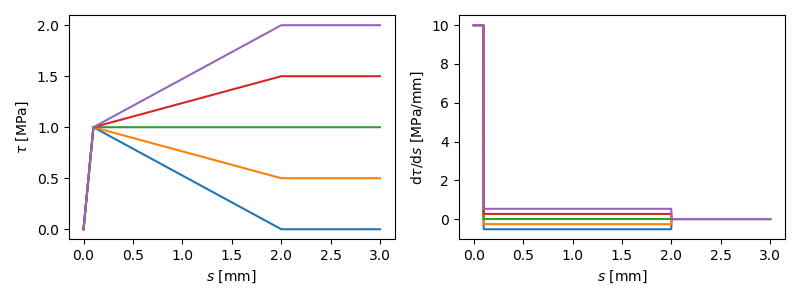

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3), tight_layout=True)
s_range = np.linspace(0, 3, 1050)
for tau_2 in [0, 0.5, 1, 1.5, 2]:
    ax1.plot(s_range, get_tau_s(s_range, 1, tau_2, 0.1, 2));
    ax2.plot(s_range, get_d_tau_s(s_range, 1, tau_2, 0.1, 2));
ax1.set_xlabel(r'$s$ [mm]'); ax1.set_ylabel(r'$\tau$ [MPa]');
ax2.set_xlabel(r'$s$ [mm]'); ax2.set_ylabel(r'$\mathrm{d}\tau/\mathrm{d}s$ [MPa/mm]');

## Numerical model of pull-out provided in BMCS Tool Suite 
The presented function is the simplest model provided in a general-purpose nonlinear finite-element simulator `BMCS-Tool-Suite`. This code can be installed in your anaconda environment by issuing the installation command

`pip install --upgrade bmcs`

After the installation it should be possible to import the `PullOutModel` by issuing

In [7]:
if True: # this is the developer shortcut - ignore
    import sys
    import os.path as op 
    hdir = op.expanduser('~')
    sys.path.insert(0,op.join(hdir,'git','bmcs'))

In [29]:
from bmcs.pullout.pullout_sim import PullOutModel
po = PullOutModel(n_e_x=60, k_max=5, w_max=1.0)
po

In [31]:
po.sim.tline.step = 0.05
po.fixed_boundary = 'loaded end (matrix)'
po.loading_scenario.trait_set(loading_type='cyclic',
                              amplitude_type='constant',
                              loading_range='non-symmetric'
                              )
po.loading_scenario.trait_set(number_of_cycles=1,
                              unloading_ratio=0.98,
                              )
po.geometry.trait_set(L_x=1.0)
po.cross_section.trait_set(A_f=1, P_b=1, A_m=1)

## What is inside the bond-slip law?

In [33]:
po.mats_eval_type = 'multilinear'
po.mats_eval.trait_set(E_m=1, E_f=1)
po.mats_eval.bs_law.replot()
po.mats_eval

## Run the simulation
The model object `po` contains the non-linear threaded simulator `sim` as its attribute. To be sure that the state arrays and history variables are zeroed and reset run the methods `stop` first. After that, the simulation can be started.

In [34]:
po.sim.stop()
po.sim.run()

Construct a figure to show the currently defined material model `mats` in graphic form. The data points of the bond slip law can be dfined as follows.

<IPython.core.display.Javascript object>


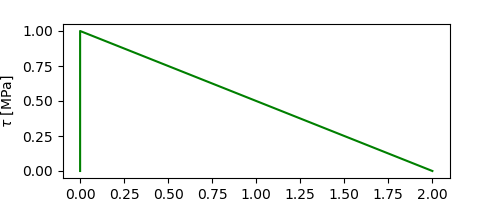

interactive(children=(FloatSlider(value=1e-06, description='s2', max=1.0, min=1e-06, step=0.3), FloatSlider(va…

In [40]:
fig, ax = plt.subplots(1,1,figsize=(5,2))
po.mats_eval.bs_law.trait_set(
    xdata=[0, 1e-6, 2.0],
    ydata=[0., 1, 1]
)
po.mats_eval.bs_law.plot(ax)
def update_bond_slip(s2, s3, tau2, tau3):
    po.mats_eval.bs_law.trait_set(
        xdata=[0, s2, s3],
        ydata=[0., tau2, tau3]
    )
    ax.clear()
    po.mats_eval.bs_law.plot(ax, color='green')
    ax.set_ylabel(r'$\tau$ [MPa]')
    ax.set_xlabel(r'$s$ [mm]')
bs_sliders = dict(s2=ipw.FloatSlider(value=1e-6, min=1e-6, max=1, step=0.3),
             s3=ipw.FloatSlider(value=2.0, min=1, max=3, step=0.3),
             tau2=ipw.FloatSlider(value=1, min=0, max=3, step=0.3),
             tau3=ipw.FloatSlider(value=1, min=0, max=3, step=0.3))
ipw.interact(update_bond_slip, **bs_sliders);

In [43]:
po.sim.stop()
po.sim.run()

<IPython.core.display.Javascript object>


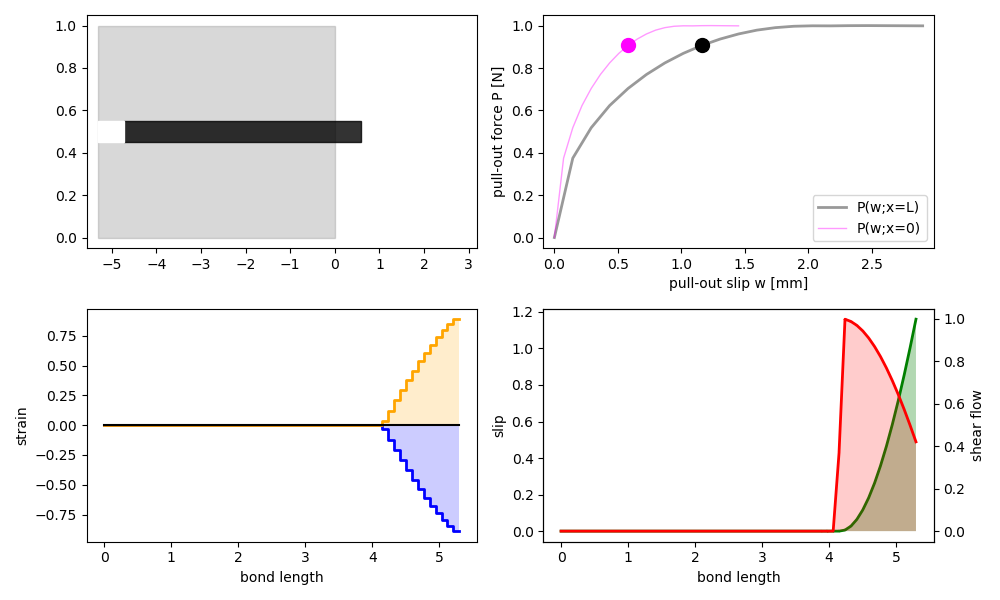

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0), Output()), _dom_classes=('widget-inter…

interactive(children=(FloatSlider(value=1.0, description='w_max', max=3.0, min=0.1), FloatSlider(value=1.0, de…

In [44]:
fix, ((ax_geo, ax_Pw),
      (ax_eps, ax_s))= plt.subplots(2,2,figsize=(10,6),
                                   tight_layout=True)
po.plot_geo(ax_geo, 0)
po.hist.plot_Pw(ax_Pw, 0)
po.plot_eps_p(ax_eps, 0)
po.plot_sig_p(ax_eps, 0)
po.plot_s(ax_s, 0)
po.mats_eval.bs_law.plot(ax_s)
ax_sf = ax_s.twinx()
po.plot_sf(ax_sf, 0)

def update_state(t):
    ax_geo.clear()
    po.plot_geo(ax_geo,t)
    ax_Pw.clear()
    po.hist.plot_Pw(ax_Pw,t)
    ax_eps.clear()
    po.plot_eps_p(ax_eps, t)
    ax_s.clear()
    po.plot_s(ax_s, t)
    ax_sf.clear()
    po.plot_sf(ax_sf, t)

def update_material(w_max, L_b, A_f, A_m, E_f, E_m):
    po.w_max = w_max
    po.geometry.L_x = L_b
    po.cross_section.A_f = A_f
    po.cross_section.A_m = A_m
    po.mats_eval.E_f = E_f
    po.mats_eval.E_m = E_m
    po.sim.stop()
    po.sim.run()
    update_state(t_slider.value)

t_slider = ipw.FloatSlider(value=0, min=0, max=1, step=0.1)
ipw.interact(update_state, t = t_slider);
m_sliders = dict(w_max=ipw.FloatSlider(value=1, min=0.1, max=3, step=0.1),
                 L_b = ipw.FloatSlider(value=1, min=0.5, max=8, step=0.1),
                 A_m = ipw.FloatSlider(value=1, min=0.5, max=100, step=10),
                 A_f = ipw.FloatSlider(value=1, min=0.5, max=10, step=1),
                 E_m = ipw.FloatSlider(value=1, min=0.5, max=30000, step=3000),
                 E_f = ipw.FloatSlider(value=1, min=0.5, max=300000, step=30000))
ipw.interact(update_material, **m_sliders );

# Tasks::
 - Identify a bond slip law that leads to a constant pullout force just avoiding a rupture of an CFRP sheet with a strength of 2 GPa. I should pull-out without breaking the sheet. In such a way we can achieve zip-fastener mechanism tuned for a particular force level. Where could such a mechanism could be applied?
 - Reproduce the RILEM pull-out test by identifying the bond-slip that can reproduce the for 16mm diameter bar. 
 - Compare the obtained bond-slip with the suggestion provided by the Model Code 2010.

## RILEM test parameters
Let us consider the case of the RILEM pullout test with the boundary condition with the following material parameters 
\begin{align}
d &= 16\;\mathrm{mm} \\
E_\mathrm{f} &= 210\;\mathrm{GPa} \\
E_\mathrm{m} &= 28\;\mathrm{GPa} \\
A_\mathrm{f} &= \pi (\frac{d}{2})^2 \;\mathrm{mm}^2 \\
A_\mathrm{m} &= (10d)^2 \;\mathrm{mm}^2 \\
p &= \pi d
\end{align}

In [45]:
d = 16.0 # [mm]
E_f = 210000 # [MPa]
E_m = 28000 # [MPa]

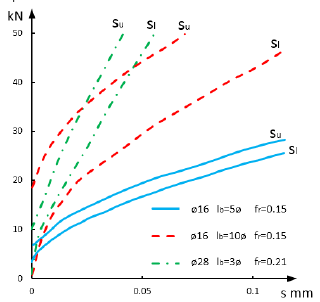

In [46]:
po_rilem = PullOutModel(mats_eval_type='multilinear',
                        n_e_x=50, k_max=200, w_max=0.1)
po_rilem.sim.tline.step = 0.005
po_rilem.mats_eval.s_tau_table = [[0, 0.0001, 0.1],
                                  [0, 3.0, 8.0]]
po_rilem.sim.run() 

<IPython.core.display.Javascript object>


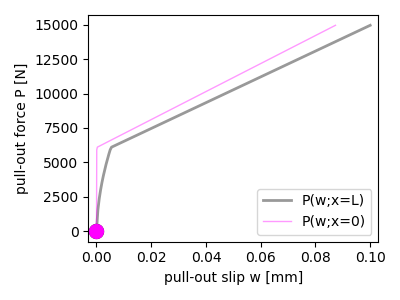

In [47]:
fix, ax = plt.subplots(1,1, figsize=(4,3),tight_layout=True)
po_rilem.hist.plot_Pw(ax, 0)